# Préparation du dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import cv2
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
import pandas as pd
import os
from glob import glob
from sklearn import preprocessing

# Chemin vers le fichier CSV contenant les données de catégories
csv_path = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/flipkart_com-ecommerce_sample_1050_champ.csv'

# Chargement du DataFrame qui contient les informations des produits, y compris 'product_category_tree'
df_categories = pd.read_csv(csv_path)

# Fonction pour extraire la première catégorie de 'product_category_tree'
def get_first_category(category_tree):
    if category_tree.startswith('["'):
        categories = category_tree[2:-2].split(' >> ')
        if categories:
            return categories[0]
    return None

# Appliquer la fonction pour créer une nouvelle colonne 'first_category'
df_categories['first_category'] = df_categories['product_category_tree'].apply(get_first_category)

# Chemin vers le dossier des images
images_path = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/Images/'
images_path_test = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/Images2/'

# Récupération des chemins des images
data_path = glob(os.path.join(images_path, '*.jpg'))
data_path_test = glob(os.path.join(images_path_test, '*.jpg'))

# Création d'un DataFrame pour les chemins des images avec leur uniq_id
df_images = pd.DataFrame({
    'image_path': data_path,
    'uniq_id': [os.path.splitext(os.path.basename(path))[0] for path in data_path]
})
df_images_test = pd.DataFrame({
    'image_path': data_path_test,
    'uniq_id': [os.path.splitext(os.path.basename(path))[0] for path in data_path_test]
})
# Fonction pour obtenir la catégorie à partir de l'identifiant unique
def photo_class(uniq_id):
    category = df_categories.loc[df_categories['uniq_id'] == uniq_id, 'first_category'].values
    if category.size > 0:
        return category[0]
    return "no_name"

# Liste des catégories valides
list_labels = ["Baby Care", "Beauty and Personal Care", "Computers", "Home Decor & Festive Needs", "Home Furnishing", "Kitchen & Dining", "Watches"]

# Associer les catégories aux images
df_images['label_name'] = df_images['uniq_id'].apply(photo_class)
df_images_test['label_name'] = df_images_test['uniq_id'].apply(photo_class)

# Encoder les labels
le = preprocessing.LabelEncoder()
le.fit(df_images['label_name'])
df_images['label'] = le.transform(df_images['label_name'])
le.fit(df_images_test['label_name'])
df_images_test['label'] = le.transform(df_images_test['label_name'])

# Vérification des données finales
print(df_images.head())
print(df_images_test.head())
# Maintenant, df_images contient le chemin de chaque image, son uniq_id, le nom de la catégorie, et la catégorie encodée.
# Ce DataFrame est prêt pour tout traitement d'image supplémentaire ou pour être utilisé pour l'entraînement de modèles.


                                          image_path  \
0  C:/Users/DELL/Desktop/OpenClass/Formation/Proj...   
1  C:/Users/DELL/Desktop/OpenClass/Formation/Proj...   
2  C:/Users/DELL/Desktop/OpenClass/Formation/Proj...   
3  C:/Users/DELL/Desktop/OpenClass/Formation/Proj...   
4  C:/Users/DELL/Desktop/OpenClass/Formation/Proj...   

                            uniq_id                label_name  label  
0  009099b1f6e1e8f893ec29a7023153c4                   Watches      6  
1  0096e89cc25a8b96fb9808716406fe94          Kitchen & Dining      5  
2  00cbbc837d340fa163d11e169fbdb952           Home Furnishing      4  
3  00d84a518e0550612fcfcba3b02b6255  Beauty and Personal Care      1  
4  00e966a5049a262cfc72e6bbf68b80e7                 Computers      2  
Empty DataFrame
Columns: [image_path, uniq_id, label_name, label]
Index: []


In [4]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]==name]
    return list_image_name

list_BC=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Baby Care"]
list_BPC=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Beauty and Personal Care"]
list_Computers=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Computers"]
list_HDFN=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Home Decor & Festive Needs"]
list_HF=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Home Furnishing"]
list_KD=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Kitchen & Dining"]
list_Watches=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Watches"]
list_Food=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="food"]


# Etape 2 : classification supervisée
2 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images


## Création du modèle de classification

In [5]:
def process_image(file_path):
    # Lire l'image en mode couleur, réduction de bruit et amélioration du contraste
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))  # Redimensionnement pour VGG16
    img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)  # Réduction de bruit
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final_img

In [6]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

## Approche préparation initiale des images

In [7]:
# Création d'un DataFrame pour les chemins des images avec leur uniq_id
df_images_test = pd.DataFrame({
    'image_path': data_path,
    'uniq_id': [os.path.splitext(os.path.basename(path))[0] for path in data_path]
})


def image_prep_fct(df_images) :
    prepared_images = []
    for image_num in range(len(df_images['image_path'])) :
        img = (load_img(
            df_images['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(df_images)
print(images_np.shape)
images_np_test = image_prep_fct(df_images_test)
print(images_np_test.shape)

c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1054, 224, 224, 3)
(1054, 224, 224, 3)


In [8]:
# Associer les catégories aux images
df_images_test['label_name'] = df_images_test['uniq_id'].apply(photo_class)

# Encoder les labels
le = preprocessing.LabelEncoder()
le.fit(df_images_test['label_name'])
df_images_test['label'] = le.transform(df_images_test['label_name'])


X = images_np
y = to_categorical(df_images['label'])

X_test = images_np_test
y_test = to_categorical(df_images_test['label'])

y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(790, 224, 224, 3)

In [10]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.keras"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [11]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.3761 - loss: 8.4607 
Epoch 1: val_loss improved from inf to 1.60412, saving model to ./model1_best_weights.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 323s 24s/step - accuracy: 0.3834 - loss: 8.2640 - val_accuracy: 0.7500 - val_loss: 1.6041
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6872 - loss: 2.0310 
Epoch 2: val_loss improved from 1.60412 to 1.18800, saving model to ./model1_best_weights.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 318s 24s/step - accuracy: 0.6877 - loss: 2.0268 - val_accuracy: 0.7841 - val_loss: 1.1880
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7569 - loss: 1.2005 
Epoch 3: val_loss did not improve from 1.18800
13/13 ━━━━━━━━━━━━━━━━━━━━ 388s 31s/step - accuracy: 0.7568 - loss: 1.2005 - val_accuracy: 0.7765 - val_loss: 1.2157
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.8108 - loss: 0.8893 
Epoch 4: val_loss improved from 1.18800 to 1.17180, saving model to ./mode

In [12]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

25/25 ━━━━━━━━━━━━━━━━━━━━ 413s 16s/step - accuracy: 0.9994 - loss: 0.0114
Training Accuracy: 0.9987

9/9 ━━━━━━━━━━━━━━━━━━━━ 133s 15s/step - accuracy: 0.8347 - loss: 1.0066
Validation Accuracy:  0.8258


In [13]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7955
Test Accuracy       :  0.9393


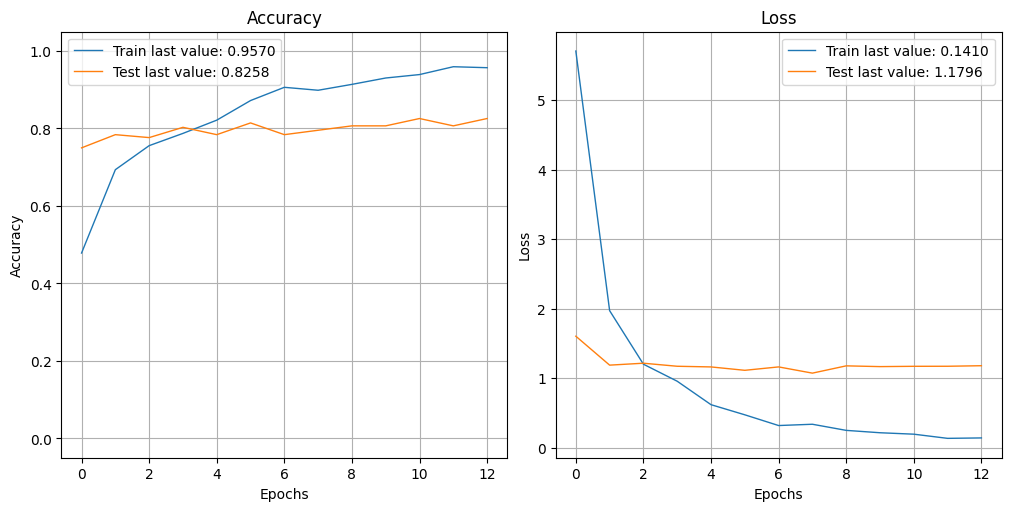

In [14]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1)
plt.close()

In [31]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [32]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 99s 10s/step
[4 0 1 2 6 3 4 4 2 3 2 4 2 1 6 6 5 0 6 0 0 0 4 5 2 4 0 4 2 6 3 3 3 1 0 5 1
 0 3 1 2 0 6 6 0 2 2 4 2 3 6 4 1 1 3 5 6 2 4 6 1 0 0 0 5 0 6 5 0 6 4 1 4 0
 1 5 3 4 3 6 4 1 0 5 5 1 2 1 1 0 3 5 5 2 2 1 6 3 6 5 5 1 5 4 1 4 3 3 2 6 4
 6 5 3 4 5 5 6 1 4 0 1 4 0 3 1 0 1 4 2 3 3 2 5 1 0 3 1 5 0 0 0 3 5 2 0 1 5
 6 1 2 6 0 0 1 1 1 3 3 4 3 1 2 5 5 3 5 2 2 4 3 1 2 5 5 2 2 0 0 3 6 0 4 5 1
 4 4 1 3 6 3 6 5 3 5 0 2 2 1 6 2 0 6 4 3 3 5 3 4 1 4 0 5 5 5 2 5 6 3 6 4 6
 2 5 4 1 4 6 6 4 1 3 6 5 6 3 6 3 2 3 2 5 6 0 2 4 5 0 4 3 0 2 4 4 2 2 5 2 6
 1 6 6 2 1]

[0 0 1 5 6 3 4 4 2 3 5 4 4 1 6 6 5 0 6 0 0 4 4 5 2 4 0 4 2 6 3 3 4 1 0 5 1
 5 3 3 2 0 6 6 0 2 2 4 2 3 6 4 1 1 3 5 6 2 3 6 1 0 0 0 0 0 6 5 3 6 4 1 4 0
 0 3 3 2 0 6 0 1 0 5 5 1 2 2 1 0 1 5 5 2 2 1 6 3 5 5 5 1 3 4 6 2 3 3 2 6 4
 6 1 3 4 5 2 1 1 0 0 1 4 0 2 1 3 3 4 5 0 3 2 5 1 0 3 1 5 0 0 1 3 5 2 6 0 5
 6 1 2 6 0 0 1 1 1 0 3 4 1 1 2 5 5 5 2 5 2 4 3 0 2 5 5 2 5 0 4 5 6 0 4 5 1
 0 4 1 3 6 5 6 5 3 5 0 2 2 0 6 2 0 6 4 3 3 5 3 4 

In [33]:
from sklearn import metrics

conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[28  1  0  3  3  1  1]
 [ 4 29  1  2  1  0  1]
 [ 0  1 29  1  1  6  0]
 [ 3  2  1 27  2  3  0]
 [ 4  0  2  1 30  0  0]
 [ 1  1  2  2  0 33  0]
 [ 0  1  0  0  0  2 34]]


In [34]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]


[[28  1  0  3  3  1  1]
 [ 4 29  1  2  1  0  1]
 [ 0  1 29  1  1  6  0]
 [ 3  2  1 27  2  3  0]
 [ 4  0  2  1 30  0  0]
 [ 1  1  2  2  0 33  0]
 [ 0  1  0  0  0  2 34]]

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        37
           1       0.83      0.76      0.79        38
           2       0.83      0.76      0.79        38
           3       0.75      0.71      0.73        38
           4       0.81      0.81      0.81        37
           5       0.73      0.85      0.79        39
           6       0.94      0.92      0.93        37

    accuracy                           0.80       264
   macro avg       0.80      0.80      0.80       264
weighted avg       0.80      0.80      0.80       264



<Axes: >

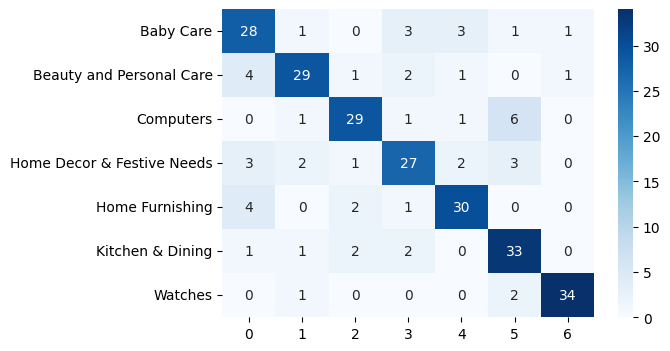

In [35]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated")

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
# Pour mélanger les images, classées initalement par classe
data = df_images.sample(frac=1, random_state=42).reset_index(drop=True)

In [38]:
batch_size = 36

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [39]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.4,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(df_images_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 791 validated image filenames belonging to 7 classes.
Found 263 validated image filenames belonging to 7 classes.
Found 1054 validated image filenames belonging to 7 classes.


In [40]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.keras"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [41]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [42]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=2)


Epoch 1/50


c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.07275, saving model to ./model2_best_weights.keras
22/22 - 345s - 16s/step - accuracy: 0.4665 - loss: 3.8568 - val_accuracy: 0.7148 - val_loss: 1.0728
Epoch 2/50

Epoch 2: val_loss improved from 1.07275 to 0.91895, saving model to ./model2_best_weights.keras
22/22 - 315s - 14s/step - accuracy: 0.6511 - loss: 1.6223 - val_accuracy: 0.7643 - val_loss: 0.9190
Epoch 3/50

Epoch 3: val_loss improved from 0.91895 to 0.76296, saving model to ./model2_best_weights.keras
22/22 - 327s - 15s/step - accuracy: 0.6877 - loss: 1.2710 - val_accuracy: 0.7605 - val_loss: 0.7630
Epoch 4/50

Epoch 4: val_loss improved from 0.76296 to 0.70602, saving model to ./model2_best_weights.keras
22/22 - 326s - 15s/step - accuracy: 0.7611 - loss: 0.8005 - val_accuracy: 0.7719 - val_loss: 0.7060
Epoch 5/50

Epoch 5: val_loss improved from 0.70602 to 0.66825, saving model to ./model2_best_weights.keras
22/22 - 290s - 13s/step - accuracy: 0.7927 - loss: 0.6808 - val_accuracy: 0

In [43]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

22/22 ━━━━━━━━━━━━━━━━━━━━ 200s 9s/step - accuracy: 0.9764 - loss: 0.0677
Training Accuracy   : 0.9760

8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 8s/step - accuracy: 0.8230 - loss: 0.7137
Validation Accuracy :  0.8137


In [44]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8023
Test Accuracy       :  0.9383


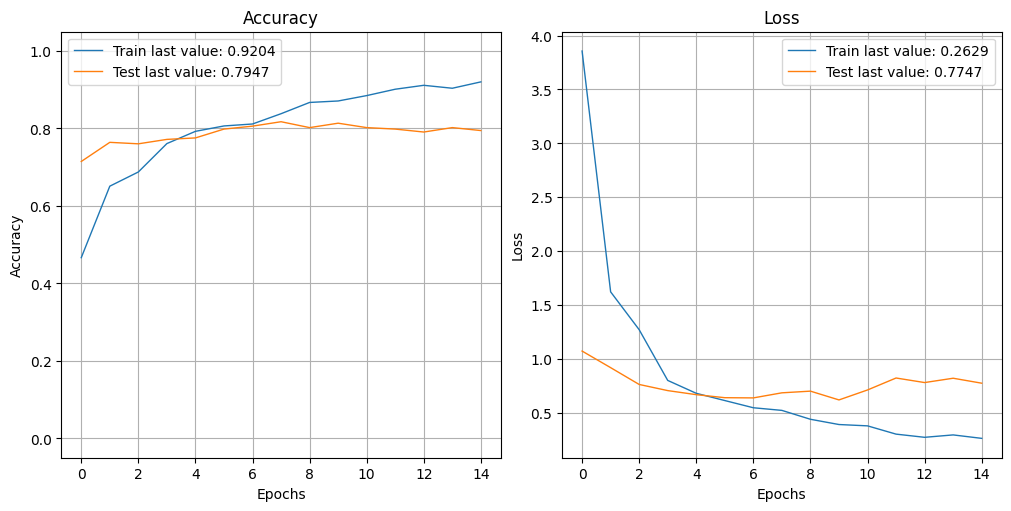

In [45]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()